In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [23]:
class_labels = ["cancer", "healthy"]

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
# Prediction function
def predict_image(image_path,model):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    print(f"Image tensor shape: {image_tensor.shape}, Image tensor dtype: {image_tensor.dtype}")

    with torch.no_grad():
        outputs = model(image_tensor)
        print(f"Model output: {outputs}")

        # Apply softmax to get probabilities for each class
        probabilities = torch.softmax(outputs, dim=1).squeeze()
        predicted = torch.argmax(probabilities).item()

        print(f"Predicted index: {predicted}")

        predicted_class = class_labels[predicted]

    return predicted_class, image


In [27]:
# Grad-CAM visualization function
def showGradMapEfficientNet_B0(path, ground_truth):
    read_tensor = transforms.Compose([
        lambda x: Image.open(x),
        lambda x: x.convert('RGB'),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        lambda x: torch.unsqueeze(x, 0)
    ])

    class Flatten(nn.Module):
        """One layer module that flattens its input."""
        def __init__(self):
            super(Flatten, self).__init__()
        def forward(self, x):
            return x.view(x.size(0), -1)

    # Load EfficientNet-B0 model
    model = torch.load('./models/EfficientNetB0/efficientNetB0.pth')
    model = model.eval().to(device)

    # Extract the features and classifier
    features_fn = nn.Sequential(*list(model.features))
    classifier_fn = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(model.classifier[1].in_features, 2)
    )

    def GradCAM(img, c, features_fn, classifier_fn):
        feats = features_fn(img)
        _, N, H, W = feats.size()
        out = classifier_fn(feats)
        c_score = out[0, c]
        grads = torch.autograd.grad(c_score, feats, retain_graph=True)
        w = grads[0][0].mean(-1).mean(-1)
        sal = torch.matmul(w, feats.view(N, H * W))
        sal = sal.view(H, W).detach().numpy()
        sal = np.maximum(sal, 0)
        return sal

    img_tensor = read_tensor(path).to(device)

    predicted_class, original_img = predict_image(path,model=model)
    print(f"Predicted class: {predicted_class}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.axis('off')

    axes[0].imshow(original_img)
    axes[0].set_title(f'Original Image ({ground_truth})')

    sal = GradCAM(img_tensor, class_labels.index(predicted_class), features_fn, classifier_fn)
    sal_img = Image.fromarray(sal)
    sal_img = sal_img.resize(original_img.size, resample=Image.BILINEAR)
    axes[1].imshow(original_img)
    axes[1].imshow(np.array(sal_img), alpha=0.31, cmap='jet')
    axes[1].set_title(f'Grad-CAM | Predicted : {predicted_class}')

    plt.subplots_adjust(wspace=0.1)
    plt.show()


Image tensor shape: torch.Size([1, 3, 224, 224]), Image tensor dtype: torch.float32
Model output: tensor([[-7.2404]])
Predicted index: 0
Predicted class: cancer


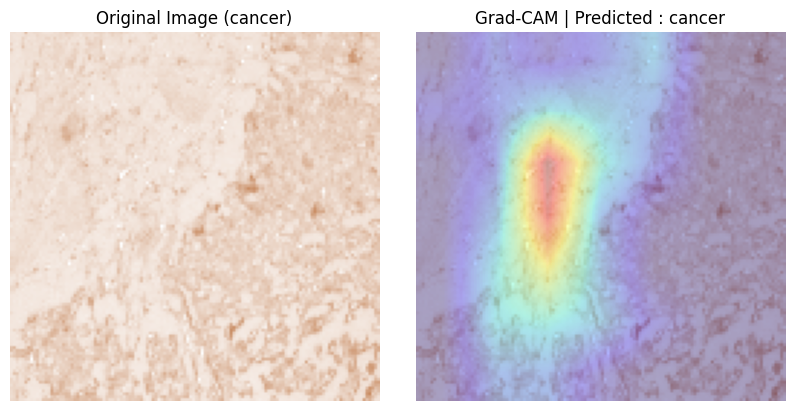

Image tensor shape: torch.Size([1, 3, 224, 224]), Image tensor dtype: torch.float32
Model output: tensor([[-9.8072]])
Predicted index: 0
Predicted class: cancer


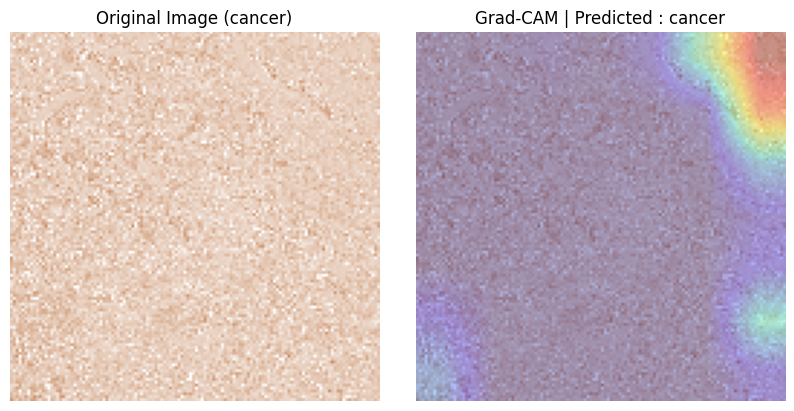

Image tensor shape: torch.Size([1, 3, 224, 224]), Image tensor dtype: torch.float32
Model output: tensor([[-8.1655]])
Predicted index: 0
Predicted class: cancer


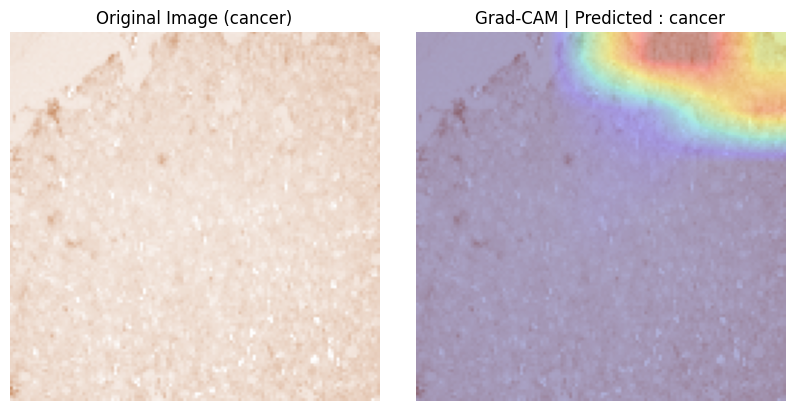

In [35]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
showGradMapEfficientNet_B0('./Dataset/CANCER/12239 (5) (1).png', 'cancer')
showGradMapEfficientNet_B0('./Dataset/CANCER/1082314-15.png', 'cancer')
showGradMapEfficientNet_B0('./Dataset/CANCER/12239 (6).png', 'cancer')